In [ ]:
# !git clone https://github.com/rosinality/stylegan2-pytorch.git
# !cd stylegan2
# !git clone https://github.com/NVlabs/stylegan2.git
# # !cp -r ./stylegan2/dnnlib ./GANasPrior3/
# # !rm -r ./stylegan2

# !python ./GANasPrior3/convert_weight.py --repo ~/stylegan2 stylegan2-ffhq-config-f.pkl
# !pip install ninja
# !pip install gdown
# !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl
# os.rename("stylegan2-pytorch","stylegan2")
# sys.path.append("./stylegan2")
# os.chdir("./stylegan2/")

In [1]:
import gdown
import shutil
from model import Generator
from torch import optim
from torch.nn import functional as F
import os
from torchvision import transforms
from PIL import Image
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# gdown.download(id = "1PQutd-JboOCOZqmd95XWxWrO8gGEvRcO")
# shutil.move("550000.pt",'checkpoint/')


/home/kaushikk/AIP/GANasPrior3/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])


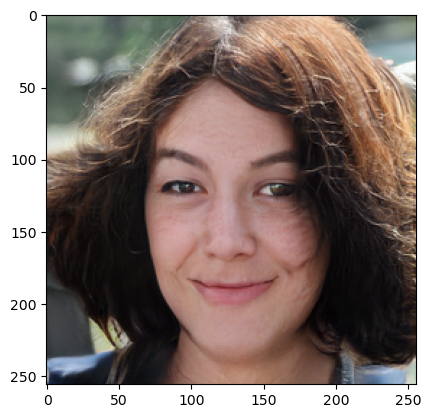

In [3]:
# !python test.py

# set torch random seed

np.random.seed(10)

resolution=256
weight_file="checkpoint/550000.pt"
g_ema = Generator(resolution, 512, 8, channel_multiplier=2).to(device)
# Load the checkpoint weights
checkpoint = torch.load(weight_file)
g_ema.load_state_dict(checkpoint["g_ema"],strict=False)
g_ema.eval()
for i in g_ema.parameters():
  i.requires_grad=False
random_latents = torch.tensor(np.random.randn(1, 512).astype(np.float32)).to(device)
# print(random_latents.shape)
images,_ = g_ema([random_latents],4096)
images = (images+1) / 2
print(images.shape)
plt.imshow(images[0].permute(1,2,0).detach().cpu().numpy())
plt.show(block=False)

In [4]:
from model import Discriminator
d = Discriminator(resolution, channel_multiplier=2).to(device)
d.eval()
for i in d.parameters():
    i.requires_grad=False

In [5]:
from skimage.metrics import structural_similarity as compare_ssim
from lpips import loss_fun

def dssim(p0, p1, range=255.):
    ssims=[]
    print(p0.shape[0])
    for i in np.arange(0,p0.shape[0]):
      ssims.append((1 - compare_ssim(p0[i], p1[i], data_range=range, multichannel=True)) / 2.)
    return np.mean(ssims)
    
def noise_regularize(noises):
    loss = 0

    for noise in noises:
        size = noise.shape[2]

        while True:
            loss = (
                loss
                + (noise * torch.roll(noise, shifts=1, dims=3)).mean().pow(2)
                + (noise * torch.roll(noise, shifts=1, dims=2)).mean().pow(2)
            )

            if size <= 8:
                break

            noise = noise.reshape([-1, 1, size // 2, 2, size // 2, 2])
            noise = noise.mean([3, 5])
            size //= 2

    return loss

def plot_loss_dict(step_losses):
    n_loss = len(step_losses)
    fig ,axs = plt.subplots(1,n_loss,figsize=(3*n_loss,3))
    if n_loss==1:
        l =list(step_losses.keys())[0]
        plt.plot(step_losses[l])
        plt.title(l)
        plt.show()
        return

    for idx,loss_name in enumerate(list(step_losses)):
        axs[idx].plot(step_losses[loss_name])
        axs[idx].set_title(loss_name)
    plt.legend()
    plt.show()


def noise_normalize_(noises):
    for noise in noises:
        mean = noise.mean()
        std = noise.std()

        noise.data.add_(-mean).div_(std)



def latent_noise(latent, strength):
    noise = torch.randn_like(latent) * strength
    return latent + noise


def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to("cpu")
        .numpy()
    )

def encoder_images(g_ema,size=256,
                   lr=0.1,noise=0.05,step=100,weight_mse=1,
                   arg_noise= 0.05,weight_noise_regularize= 1e5,weight_perceptual=1,weight_diss=0,
                   diss_model =None,
                   files=None,w_plus=True,return_val=False,out_dir="./output/"):
    os.makedirs(out_dir,exist_ok=True)
    n_mean_latent = 10000

    resize = min(size, 256)

    transform = transforms.Compose(
        [
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    imgs = []

    for imgfile in files:
        img = transform(Image.open(imgfile).convert("RGB"))
        imgs.append(img)

    imgs = torch.stack(imgs, 0).to(device)

    with torch.no_grad():
        noise_sample = torch.randn(n_mean_latent, 512, device=device)
        latent_out = g_ema.style(noise_sample)

        latent_mean = latent_out.mean(0)
        latent_std = ((latent_out - latent_mean).pow(2).sum() / n_mean_latent) ** 0.5



    noises_single = g_ema.make_noise()
    noises = []
    for noise in noises_single:
        noises.append(noise.repeat(imgs.shape[0], 1, 1, 1).normal_())

    latent_in = latent_mean.detach().clone().unsqueeze(0).repeat(imgs.shape[0], 1)

    if w_plus:
        latent_in = latent_in.unsqueeze(1).repeat(1, g_ema.n_latent, 1)

    latent_in.requires_grad = True

    for noise in noises:
        noise.requires_grad = True

    loss_module = loss_fun(l_mse=weight_mse, l_perceptual=weight_perceptual, l_diss=weight_diss,l_diss_model=diss_model) 
    # optimizer = optim.Adam([latent_in] + noises, lr=lr,betas=(0.9,0.99),eps=1e-8)
    optimizer = optim.Adam([latent_in], lr=lr,betas=(0.9,0.99),eps=1e-8)

    pbar = tqdm(range(step))
    latent_path = []

    step_losses={}

    for i in pbar:
        t = i / step
        # lr = get_lr(t, lr)
        # optimizer.param_groups[0]["lr"] = lr
        lr = optimizer.param_groups[0]["lr"]
        noise_strength = latent_std * arg_noise * max(0, 1 - t / noise_ramp) ** 2
        latent_n = latent_noise(latent_in, noise_strength.item())

        # img_gen, _ = g_ema([latent_n], input_is_latent=True, noise=noises)
        img_gen, _ = g_ema([latent_n], input_is_latent=True)

        batch, channel, height, width = img_gen.shape

        if height > 256:
            factor = height // 256

            img_gen = img_gen.reshape(
                batch, channel, height // factor, factor, width // factor, factor
            )
            img_gen = img_gen.mean([3, 5])

        loss,loss_dict = loss_module(img_gen,imgs)     
        n_loss = noise_regularize(noises)
        

        loss = loss + weight_noise_regularize * n_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        noise_normalize_(noises)

        if (i + 1) % 100 == 0:
            latent_path.append(latent_in.detach().clone())

        pbar.set_description(
            (
                f"perceptual: {loss_dict.get('percetual',0):.4f}; noise regularize: {n_loss.item():.4f};"
                f" mse: {loss_dict.get('mse',0):.4f}; lr: {lr:.4f}"
                f" diss_loss : {loss_dict.get('diss',0):.4f}"
            )
        )
        for loss_name in loss_dict:
            if loss_name in step_losses:
                step_losses[loss_name].append(loss_dict[loss_name])
            else:
                step_losses[loss_name] = [loss_dict[loss_name]]
    img_gen, _ = g_ema([latent_path[-1]], input_is_latent=True, noise=noises)

    filename = out_dir+os.path.splitext(os.path.basename(files[0]))[0] + ".pt"

    img_ar = make_image(img_gen)
    # Create Image to store the value
    img_ar = make_image(img_gen)

    result_file = {}
    for i, input_name in enumerate(files):
        noise_single = []
        for noise in noises:
            noise_single.append(noise[i : i + 1])

        result_file[input_name] = {
            "img": img_gen[i],
            "latent": latent_in[i],
            "noise": noise_single,
        }
        img_name = out_dir+os.path.splitext(os.path.basename(input_name))[0] + "-project.png"
        pil_img = Image.fromarray(img_ar[i])
        pil_img.save(img_name)
    
    torch.save(result_file, filename)

    if return_val:
      return img_gen,latent_in,noises,step_losses

In [6]:
# files = ['./sample/63900.png','sample/63911.png','sample/63932.png','sample/63948.png']
# files = ['./sample/1000.jpg','sample/10002.jpg','sample/10019.jpeg','sample/1012.jpg',]
size=256
lr=0.1
noise=0.05
noise_ramp=0.75
step=5000
weight_mse=1
weight_perceptual=0
arg_noise= 0.05
weight_noise_regularize= 1e5
w_plus=True
return_val=False
out_dir="./output/"
dir_='./sample2/'
files= [dir_+i for i in os.listdir(dir_,) if os.path.basename(i).split(".")[-1] in {'jpg','png','jpeg'} ]
files

['./sample2/1s_p.jpg',
 './sample2/2gauss.png',
 './sample2/1gauss.png',
 './sample2/2jpeg.jpg',
 './sample2/3s_p.jpg',
 './sample2/3jpeg.jpg',
 './sample2/2s_p.jpg',
 './sample2/1jpeg.jpg',
 './sample2/3gauss.png']

In [7]:
img_ar,latents,noises,step_losses = encoder_images(g_ema,files=files,step=5000,
                                       weight_mse=1,
                                       weight_noise_regularize=0,
                                       weight_perceptual=0,
                                       lr=0.1,arg_noise=0.05,w_plus=True,
                                       return_val=True,out_dir='./output2/mse1_percept0/')

  0%|          | 0/5000 [00:00<?, ?it/s]/home/kaushikk/AIP/GANasPrior3/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
perceptual: 0.0000; noise regularize: 0.0205; mse: 0.0048; lr: 0.1000 diss_loss : 0.0000: 100%|██████████| 5000/5000 [15:16<00:00,  5.46it/s]


In [8]:
img_ar,latents,noises,step_losses = encoder_images(g_ema,files=files,step=5000,
                                       weight_mse=0,
                                       weight_noise_regularize=0,
                                       weight_perceptual=1,
                                       lr=0.1,arg_noise=0.05,w_plus=True,
                                       return_val=True,out_dir='./output2/mse0_percept1/')

Setting up Perceptual loss...


/home/kaushikk/miniconda3/envs/ganasprior/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/kaushikk/miniconda3/envs/ganasprior/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/kaushikk/AIP/GANasPrior3/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


perceptual: 1.3122; noise regularize: 0.0518; mse: 0.0000; lr: 0.1000 diss_loss : 0.0000: 100%|██████████| 5000/5000 [21:30<00:00,  3.87it/s]


In [9]:
img_ar,latents,noises,step_losses = encoder_images(g_ema,files=files,step=5000,
                                       weight_mse=1,
                                       weight_noise_regularize=1e5,
                                       weight_perceptual=1,
                                       lr=0.1,arg_noise=0.05,w_plus=True,
                                       return_val=True,out_dir='./output2/mse1_percept1/')

Setting up Perceptual loss...
Loading model from: /home/kaushikk/AIP/GANasPrior3/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


perceptual: 1.2635; noise regularize: 0.0178; mse: 0.0159; lr: 0.1000 diss_loss : 0.0000: 100%|██████████| 5000/5000 [22:12<00:00,  3.75it/s]


perceptual: 0.0000; noise regularize: 0.0125; mse: 0.0000; lr: 0.1000 diss_loss : 0.0062: 100%|██████████| 5000/5000 [26:29<00:00,  3.15it/s]


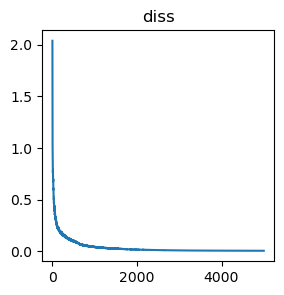

In [10]:
# Get Noisy Image
img_ar,latents,noises,step_losses = encoder_images(g_ema,files=files,step=5000,
                                       weight_mse=0,
                                       weight_noise_regularize=1e5,
                                       weight_perceptual=0,
                                       weight_diss=1000,
                                       diss_model=d,
                                       lr=0.1,arg_noise=0.05,w_plus=True,
                                       return_val=True,out_dir='./output2/diss1000_mse0_percept0/')
plot_loss_dict(step_losses)

In [11]:
img_ar,latents,noises,step_losses = encoder_images(g_ema,files=files,step=5000,
                                       weight_mse=1,
                                       weight_noise_regularize=1e5,
                                       weight_perceptual=0,
                                       weight_diss=1000,
                                       diss_model=d,
                                       lr=0.1,arg_noise=0.05,w_plus=True,
                                       return_val=True,out_dir='./output2/diss1000_mse1_percept0/')
plot_loss_dict(step_losses)

perceptual: 0.0000; noise regularize: 0.0256; mse: 0.0135; lr: 0.1000 diss_loss : 0.0291:  34%|███▍      | 1709/5000 [09:00<17:20,  3.16it/s]


KeyboardInterrupt: 

Setting up Perceptual loss...
Loading model from: /home/kaushikk/AIP/GANasPrior3/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


perceptual: 1.2893; noise regularize: 0.0095; mse: 0.0147; lr: 0.1000 diss_loss : 0.0262: 100%|██████████| 5000/5000 [31:56<00:00,  2.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


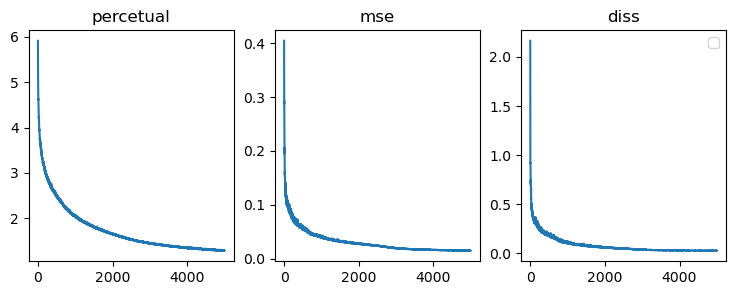

In [12]:
img_ar,latents,noises,step_losses = encoder_images(g_ema,files=files,step=5000,
                                       weight_mse=1,
                                       weight_noise_regularize=1e5,
                                       weight_perceptual=1,
                                       weight_diss=1000,
                                       diss_model=d,
                                       lr=0.1,arg_noise=0.05,w_plus=True,
                                       return_val=True,out_dir='./output2/diss1000_mse1_percept1/')
plot_loss_dict(step_losses)